In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import layers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AtrousConvolution2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import models

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

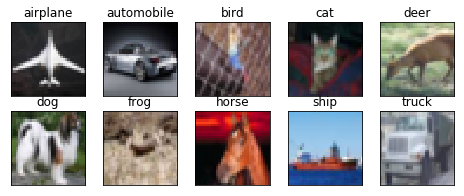

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [13]:
# Define the model

input_network = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(48,3,3,border_mode='same', activation='relu',)(input_network)
x = layers.Conv2D(48,3,3,border_mode='same', activation='relu',)(x)
x = layers.Conv2D(48,3,3, activation='relu',)(x)
x = layers.Conv2D(48,3,1, activation='relu',)(x)
x = layers.Conv2D(48,1,3, activation='relu',)(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(96,3,3,border_mode='same', activation='relu',)(x)
x = layers.SeparableConv2D(96, 1, 1)(x)
x = layers.AtrousConvolution2D(96, 3, 3,atrous_rate=(2,2),border_mode='valid', activation='relu',)(x)
x = layers.SeparableConv2D(48, 1, 1)(x)
x = layers.Conv2D(48,3,3,border_mode='same', activation='relu',)(x)

group11 = layers.Conv2D(48,3,3,border_mode='same', activation='relu',)(x)
group11 = layers.SeparableConv2D(96, 1, 1)(group11)
group11 = layers.Conv2D(96,3,3,border_mode='same', activation='relu',)(group11)
group11 = BatchNormalization()(group11)

group12 = layers.Conv2D(48,5,5,border_mode='same', activation='relu',)(x)
group12 = layers.SeparableConv2D(128, 1, 1)(group12)
group12 = layers.Conv2D(128,5,5,border_mode='same', activation='relu',)(group12)
group12 = BatchNormalization()(group12)
group12 = layers.SeparableConv2D(96, 1, 1)(group12)

x = layers.add([group11, group12])
x = layers.Conv2D(96,3,3,border_mode='same', activation='relu',)(x)

group21 = layers.AtrousConvolution2D(96, 3, 3,atrous_rate=(1,1),border_mode='same', activation='relu',)(x)
group21 = layers.SeparableConv2D(128, 1, 1)(group21)
group21 = layers.AtrousConvolution2D(128, 3, 3,atrous_rate=(1,1),border_mode='same', activation='relu',)(group21)
group21 = layers.SeparableConv2D(96, 1, 1)(group21)

group22 = layers.AtrousConvolution2D(96, 3, 3,atrous_rate=(2,2),border_mode='same', activation='relu',)(x)
group22 = layers.SeparableConv2D(128, 1, 1)(group22)
group22 = layers.AtrousConvolution2D(128, 3, 3,atrous_rate=(2,2),border_mode='same', activation='relu',)(group22)
group22 = layers.SeparableConv2D(96, 1, 1)(group22)

x = layers.add([group21, group22])

x = layers.Conv2D(96, 3, 3,activation ='relu',)(x)
x = layers.Conv2D(96, 3, 3,activation ='relu',)(x)
x = layers.Conv2D(96, 3, 3)(x)
x = layers.Conv2D(96, 3, 3)(x)
x = layers.Conv2D(10, 2)(x)
x = layers.Flatten()(x)
x = layers.Activation('softmax')(x)

model = models.Model(inputs=[input_network], outputs=[x])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), activation="relu", padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), activation="relu")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 1), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (1, 3), activation="relu")`
  import sys
/usr/loca

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 32, 32, 48)   1344        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 32, 32, 48)   20784       conv2d_62[0][0]                  
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 30, 30, 48)   20784       conv2d_63[0][0]                  
__________________________________________________________________________________________________
conv2d_65 

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=40)`
  if sys.path[0] == '':


Epoch 1/40
390/390 [==============================] - 34s 87ms/step - loss: 2.0385 - acc: 0.2019 - val_loss: 2.1919 - val_acc: 0.2275
Epoch 2/40
390/390 [==============================] - 28s 73ms/step - loss: 1.6746 - acc: 0.3631 - val_loss: 1.7774 - val_acc: 0.3813
Epoch 3/40
390/390 [==============================] - 28s 71ms/step - loss: 1.4473 - acc: 0.4634 - val_loss: 1.5528 - val_acc: 0.4439
Epoch 4/40
390/390 [==============================] - 28s 71ms/step - loss: 1.2891 - acc: 0.5303 - val_loss: 1.4001 - val_acc: 0.4984
Epoch 5/40
390/390 [==============================] - 28s 71ms/step - loss: 1.1656 - acc: 0.5769 - val_loss: 1.5125 - val_acc: 0.4953
Epoch 6/40
390/390 [==============================] - 28s 71ms/step - loss: 1.0757 - acc: 0.6124 - val_loss: 1.1153 - val_acc: 0.5981
Epoch 7/40
390/390 [==============================] - 28s 71ms/step - loss: 1.0000 - acc: 0.6425 - val_loss: 1.2002 - val_acc: 0.5693
Epoch 8/40
390/390 [==============================] - 28s 71ms

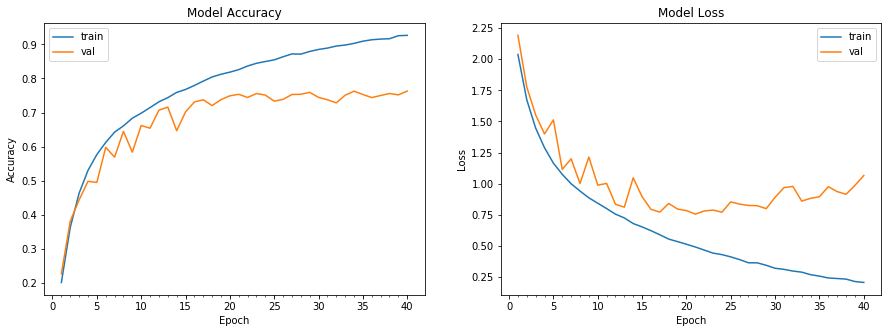

Accuracy on test data is: 76.31


In [15]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 40, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))